In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import matplotlib.dates as md
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns

from yellowbrick.target import ClassBalance

sns.set()

### Visualization Functions

The following functions will be used throughout this notebook to visualize the data for each of the sensors.

In [3]:
def lineplot(data, title, x_label, y_label):
    _, ax = plt.subplots()
    
    ax.boxplot(data)
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

In [4]:
def plotBoxplots(df, column, title):
    """Plot boxplots for each day of data."""
    
    # Create dataframe with a daily PeriodIndex
    df_period = df.to_period(freq='D')
    
    # Boxplots for daily sensor data
    fig, ax = plt.subplots(figsize=(16,8))
    
    sns.boxplot(
        x=df_period.index, y=column, data=df_period,
        ax=ax, palette=sns.color_palette('RdBu', 10)
    )
    
    # Set the plot title
    ax.set_title(title, fontsize=22)
    
    # Set the x-axis and y-axis labels
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel(title, fontsize=14)
    
    # Create list of dates for the x-ticks labels
    labels = (
        ['March 25', 'April 1', 'April 8', 'April 22', 'April 29',
         'May 5', 'May 6', 'May 12', 'May 13', 'June 3', 'June 10']
    )
    
    # Set x-ticks labels
    ax.set_xticklabels(labels, size=12)

    # Show plot
    plt.show()

In [5]:
def plotHistogram(df, column, title):
    """Plot a histogram of the sensor data."""
    
    # Calculate number of hist bins
    n_data = len(df[column])
    n_bins = int(np.sqrt(n_data))
    
    fig, ax = plt.subplots()
    
    ax.hist(
            df[column], bins=n_bins,
            range=(df[column].min(), df[column].max()))
    
    # Set the plot title
    ax.set_title(title, size=18)
    
    # Set the ylabel
    ax.set_ylabel('Count')
    
    # Set the x-ticks and y-ticks parameters
    ax.xaxis.set_major_formatter(
        tkr.FuncFormatter(lambda x,  p: format(int(x), ',')))
    
    ax.yaxis.set_major_formatter(
        tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))
    
    # Show plot
    plt.show()

# Import & Clean Sensor Data

As a student in Georgetown University's Data Science Certificate Program, I worked with four other students on a semester long Capstone project that used Raspberry Pi 3 Model B and other devices to capture sensor data from our classroom. My primary role on the team involved cleaning the data and building the machine learning models.

In this notebook, I'll ingest the data and clean each sensor separately, since this will make it easier to explore the data and to identify potential outliers. Once finished, I will concatenate the individual DataFrames and backfill any missing data.

## Data Ingestion

The `sensor_data.csv` file contains 46,275 observations and contains the following features: location, location_CO2, temperature, humidity, sound, bluetooth devices, and non-personal bluetooth devices.

In [6]:
# Read csv file in as a Pandas DataFrame with a DateTimeIndex: df
df = pd.read_csv('../data/sensor_data.csv', index_col='datetime', parse_dates=True)

df.columns = [
    'loc', 'loc2', 'temperature', 'humidity', 'co2', 'light',
    'sound', 'bluetooth_devices', 'nonpersonal_bluetooth'
]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 46275 entries, 2017-03-25 09:05:58 to 2017-06-10 16:47:05
Data columns (total 9 columns):
loc                      46275 non-null object
loc2                     46275 non-null object
temperature              46275 non-null float64
humidity                 46275 non-null float64
co2                      46275 non-null float64
light                    46275 non-null float64
sound                    46275 non-null float64
bluetooth_devices        46275 non-null int64
nonpersonal_bluetooth    38187 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 3.5+ MB


When the project first began, our team had debated the idea of gathering data from other classrooms, which is why this dataset contains two location columns. However, since it only contains data from our classroom, I can drop these columns.

I'll also drop the `nonpersonal_bluetooth` feature, which was not added until April 8th, so there are two days of missing data. In addition, as you can see below, it is very highly correlated with `bluetooth_devices`.

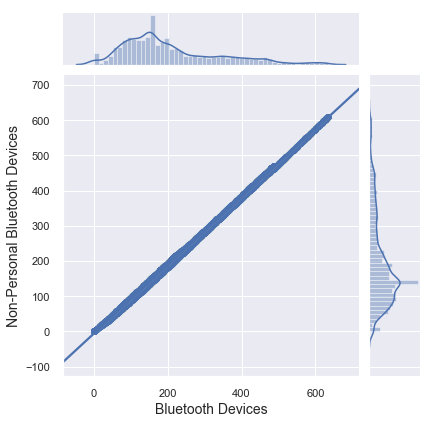

In [8]:
# Jointplot of bluetooth devices and non-personal bluetooth devices
sns.jointplot(
    x='bluetooth_devices', y='nonpersonal_bluetooth',
    data=df.dropna(), kind='reg')

plt.xlabel('Bluetooth Devices', fontsize=14)
plt.ylabel('Non-Personal Bluetooth Devices', fontsize=14)
plt.show()

In [9]:
# Delete the non-personal bluetooth and two location columns
df.drop(['loc', 'loc2', 'nonpersonal_bluetooth'], axis=1, inplace=True)

### Dataset Overview

Grouping by day shows that we have data for 11 class periods. Each day has a different number of values, since it wasn't possible to begin and end recording at the exact time each day. In addition, Friday night classes were only 3 hours long, from 6:30 PM to 9:30 PM EST, while Saturday classes were 7 hours, from 9:00 AM to 4:00 PM EST. This is why there are significantly fewer observations on May 5th, May 12th, and June 3rd.

In [10]:
# Use groupby to see which days are captured in the data
df.groupby(df.index.strftime('%D')).count()

,temperature,humidity,co2,light,sound,bluetooth_devices
03/25/17,3711,3711,3711,3711,3711,3711
04/01/17,4377,4377,4377,4377,4377,4377
04/08/17,4575,4575,4575,4575,4575,4575
04/22/17,5298,5298,5298,5298,5298,5298
04/29/17,5039,5039,5039,5039,5039,5039
05/05/17,2390,2390,2390,2390,2390,2390
05/06/17,5320,5320,5320,5320,5320,5320
05/12/17,2083,2083,2083,2083,2083,2083
05/13/17,5195,5195,5195,5195,5195,5195
06/03/17,2745,2745,2745,2745,2745,2745


## Data Wrangling

The initial exploratory data analysis showed that the several of the sensors had generated multiple error values. Most often, these readings occurred at the beginning and end of the day when the devices were turned on and off. However, there were also cases when the sensors would restart, causing either error values and creating gaps of missing data.

Some of the error values were easy to identify, such as a temperature reading of -999.99 °Celsius. However others, such as a CO&#8322; value of 2, required further investigation, since without any domain knowledge, I couldn’t be certain if 2 was a low, but accurate reading.

### Temperature Data

    Type of Sensor: AM2303 (captures both temperature and humidity)  
    Sensor Range: -40 to 125°C

    Reference: OSHA recommends temperature control in the range of 20-24.4°C (68-76°F). 

In [11]:
# Create temperature dataframe with a DateTimeIndex
temperature_data = df[['temperature']].copy()

The temperature data has two -999 values. Below, we can see that on April 8th it was the first value of the day, while the second occurred on May 6th during the first hour of class. In addition, because the AM2303 sensor captures both temperature and relative humidity, these same -999 errors allow show up in the humidity data.

In [12]:
# Summary statistics for the temperature data
temperature_data.describe()

,temperature
count,46275.000000
mean,23.022280
std,6.845733
min,-999.000000
25%,22.400000
50%,22.900000
75%,23.200000
max,29.400000


In [13]:
# Show when the first -999 value was recorded
temperature_data['2017-04-08'].head()

,temperature
datetime,
2017-04-08 08:58:39,-999.0
2017-04-08 08:58:44,21.8
2017-04-08 08:58:50,21.8
2017-04-08 08:58:55,21.8
2017-04-08 08:59:00,21.8


In [14]:
# Show when the second -999 temperature value was recorded
temperature_data['2017-05-06 09:22:05':'2017-05-06 09:22:20']

,temperature
datetime,
2017-05-06 09:22:06,23.2
2017-05-06 09:22:11,23.1
2017-05-06 09:22:12,-999.0
2017-05-06 09:22:16,23.1
2017-05-06 09:22:17,22.7


Since even Neptune, the coldest planet in our solar system (sorry Pluto!), has an average temperature of -214°C, the -999 values are obviously errors generated by the sensor, so I'll delete them. 

In [15]:
# Delete two -999 values from the temperature data
temperature_data = temperature_data[temperature_data['temperature'] != -999]

In [16]:
# Updated summary statistics for the temperature data
temperature_data.describe()

,temperature
count,46273.000000
mean,23.066453
std,1.310251
min,20.700000
25%,22.400000
50%,22.900000
75%,23.200000
max,29.400000


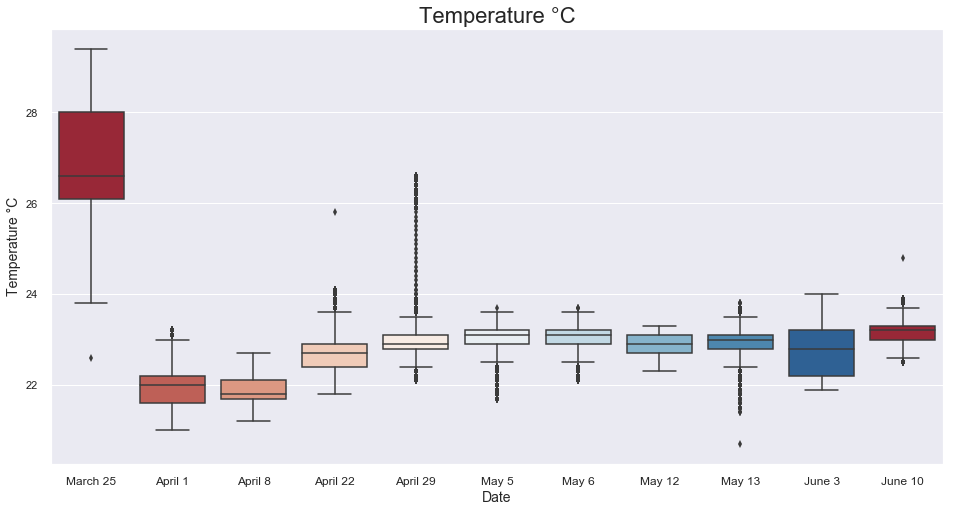

In [17]:
# Plot boxplots of the daily temperature data
plotBoxplots(temperature_data, 'temperature', 'Temperature °C')

The boxplots show single outliers for certain days, such as for March 25th, May 13th, and June 10th. Further investigation found that these values are from the initial sensor reading from that particular day (please see below). While the difference between the first reading and the following values may not seem as significant at first, the dataframe's standard deviation is only 1.4, so it is important to address them. Since the values are relatively close, I will delete them here and they will be backfilled later when I concatenate the data back into a single DataFrame.

In [18]:
# Look at the first value from April 22, 2017
temperature_data.loc['2017-04-22'].head()

,temperature
datetime,
2017-04-22 08:35:29,25.8
2017-04-22 08:35:34,22.7
2017-04-22 08:35:39,22.6
2017-04-22 08:35:44,22.6
2017-04-22 08:35:49,22.6


In [19]:
# Look at the first temperature value from May 13, 2017
temperature_data['2017-05-13'].head()

,temperature
datetime,
2017-05-13 08:57:13,20.7
2017-05-13 08:57:18,21.4
2017-05-13 08:57:23,21.4
2017-05-13 08:57:28,21.4
2017-05-13 08:57:33,21.5


In [20]:
# Look at the first temperature value from June 10, 2017
temperature_data['2017-06-10'].head()

,temperature
datetime,
2017-06-10 09:03:10,24.8
2017-06-10 09:03:15,23.6
2017-06-10 09:03:20,23.6
2017-06-10 09:03:25,23.5
2017-06-10 09:03:30,23.5


Since the first temperature values recorded for each class period were outliers created by the sensor, I'll delete those from the data.

In [21]:
# Group the temperature data by day
temp_data = temperature_data.groupby(temperature_data.index.date).head(1)

# Drop the first temperature value for each day
temperature_data = temperature_data.drop(temp_data[temp_data == 1].index)

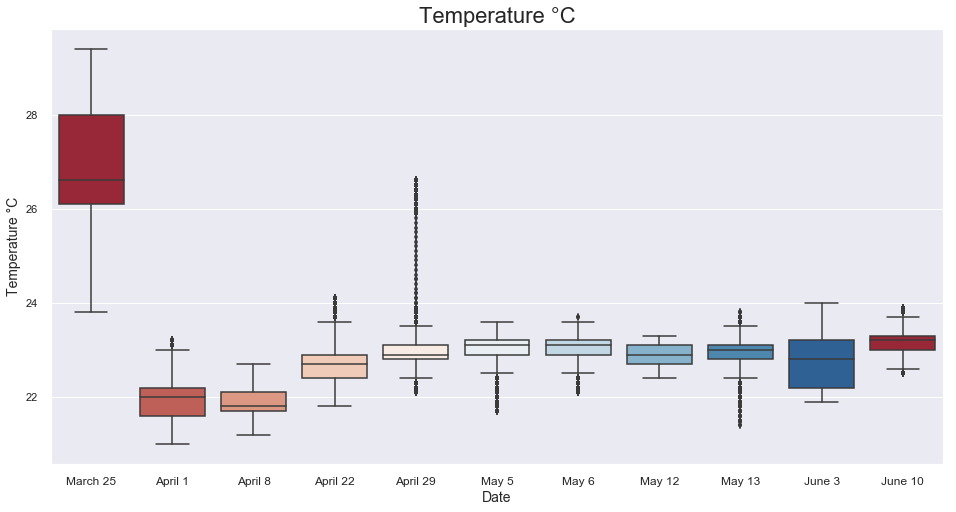

In [22]:
# Updated boxplots of the daily temperature data
plotBoxplots(temperature_data, 'temperature', 'Temperature °C')

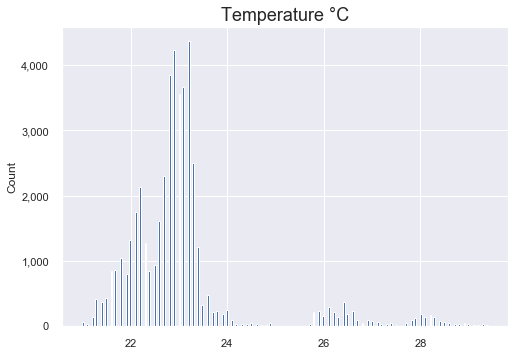

In [23]:
# Plot a histogram of the temperature data
plotHistogram(temperature_data, 'temperature', 'Temperature °C')

#### Resample Temperature Data

The temperature data was original taken at 5-second intervals, so I'll resample it now 1-minute frequency by taking the mean of the values.

In [24]:
# Resample temperature data 
temperature = temperature_data.resample('T').mean().dropna()

In [25]:
# Updated temperature summary statistics
temperature.describe()

,temperature
count,4155.000000
mean,23.116235
std,1.427802
min,21.000000
25%,22.300000
50%,22.900000
75%,23.200000
max,29.350000


### Humidity

    Type of Sensor: AM2303
    Sensor Range: 0-100% RH

    Reference: OSHA recommends humidity control in the range of 20%-60%.

In [26]:
# Create humidity dataframe with DateTimeIndex: humidity_data
humidity_data = df[['humidity']].copy()

Our sensor captured both temperature and humidity together, which is why the humidity data also contains two -999 values.

In [27]:
# Summary statistics for the humidity data
humidity_data.describe()

,humidity
count,46275.000000
mean,39.769657
std,9.471097
min,-999.000000
25%,37.800000
50%,40.100000
75%,45.100000
max,52.200000


In [28]:
# Delete two -999 values
humidity_data = humidity_data[humidity_data['humidity'] != -999]

In [29]:
# Updated humidity statistics
humidity_data.describe()

,humidity
count,46273.000000
mean,39.814555
std,6.562350
min,20.800000
25%,37.800000
50%,40.100000
75%,45.100000
max,52.200000


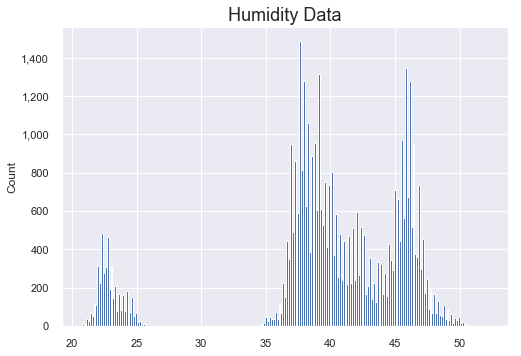

In [30]:
# Plot a histogram of the humidity data
plotHistogram(humidity_data, 'humidity', 'Humidity Data')

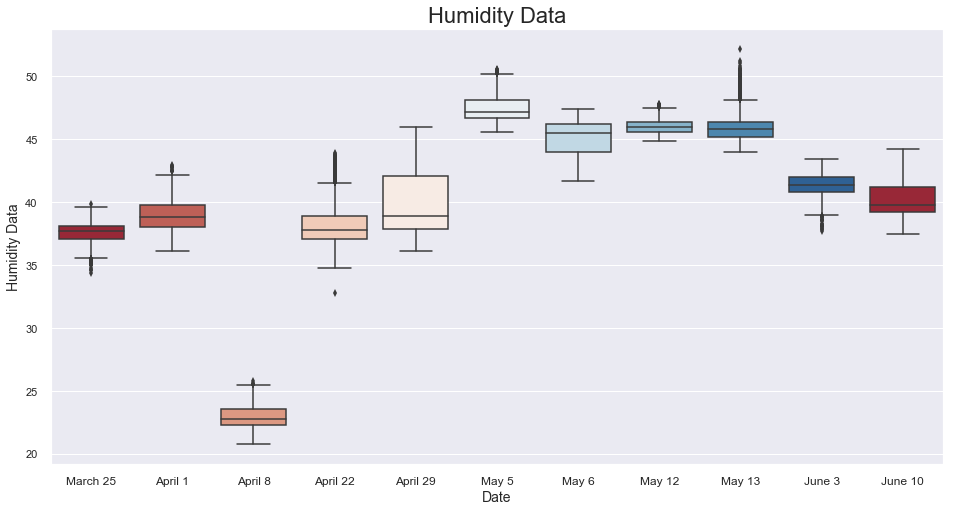

In [31]:
# Plot boxplots of the daily humidity data
plotBoxplots(humidity_data, 'humidity', 'Humidity Data')

In [32]:
# TO DO: Look into why the data April 8 differs so greatly from the others.

In [33]:
# Resample the humidity data
humidity = humidity_data.resample('T').mean().dropna()

In [34]:
# Updated humidity summary statistics
humidity.describe()

,humidity
count,4157.000000
mean,39.581197
std,6.547206
min,21.190909
25%,37.730000
50%,39.716667
75%,44.916667
max,50.730000


### CO&#8322; Data

    Type of Sensor: COZIR Ambient GC-0010 Sensor
    Sensor Range: 0-2000 parts per million (ppm)

    Reference: OSHA recommends keeping indoor CO2 levels below 1000 ppm.   

In [35]:
# Create CO2 dataframe with DateTimeIndex: co2_data
co2_data = df[['co2']].copy()

The summary statistics report a mean of 1236.25 and a standard deviation of 178.46. However, I noticed that the 25% quartile has a range of 2 to 1110, which was significantly larger than the others.

While the -999 temperature and humidity values were obviously errors, without any domain knowledge, I didn't initially know if a CO&#8322; value of 2 was caused by a sensor error or was a low, but accurate, reading. 

In [36]:
# Summary statistics for the CO2 data
co2_data.describe()

,co2
count,46275.00000
mean,1236.24510
std,178.36047
min,2.00000
25%,1110.00000
50%,1261.00000
75%,1355.00000
max,2001.00000


The sensor randomly generated thirty-three error 2 values, with several recorded as the first value of the day.

In [37]:
# Identify how many 2 values are in the data
len(co2_data[co2_data['co2'] == 2])

33

In [38]:
# Look at the first CO2 value from April 8, 2017
co2_data.loc['2017-04-08'].head()

,co2
datetime,
2017-04-08 08:58:39,2.0
2017-04-08 08:58:44,792.0
2017-04-08 08:58:50,776.0
2017-04-08 08:58:55,763.0
2017-04-08 08:59:00,776.0


In [39]:
# Look at the first CO2 value from June 10, 2017
co2_data.loc['2017-06-10'].head()

,co2
datetime,
2017-06-10 09:03:10,2.0
2017-06-10 09:03:15,1290.0
2017-06-10 09:03:20,1310.0
2017-06-10 09:03:25,1293.0
2017-06-10 09:03:30,1333.0


In [40]:
# Delete 2 values
co2_data = co2_data[co2_data['co2'] != 2]

In [41]:
# Updated CO2 statistics
co2_data.describe()

,co2
count,46242.000000
mean,1237.125903
std,175.348893
min,629.000000
25%,1110.000000
50%,1261.000000
75%,1355.000000
max,2001.000000


On April 1, 2017, the CO&#8322; sensor readings suddenly spiked up to 2001, as you can see below. The sensor was only supposed to have a range of 0-2000 ppm.

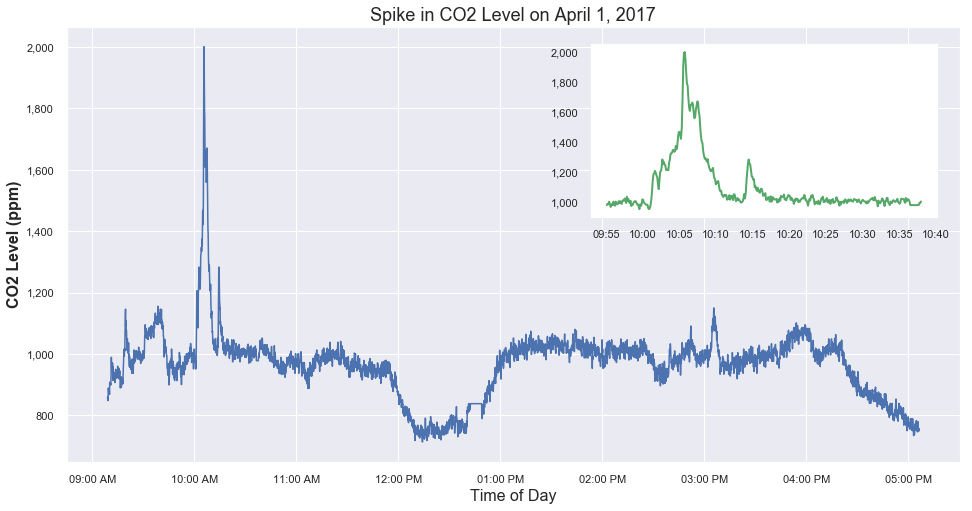

In [42]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(16,8))

# Plot spike in CO2 level on April 1, 2017
ax.plot(co2_data.loc['April 1, 2017'])

# Add title and labels
ax.set_title('Spike in CO2 Level on April 1, 2017', fontsize=18)
ax.set_ylabel('CO2 Level (ppm)', fontsize=16, weight='bold')
ax.set_xlabel('Time of Day', fontsize=16)
ax.xaxis.set_major_formatter(md.DateFormatter('%I:%M %p'))
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))

# Create inset
ax = plt.axes([.58, .55, .3, .3], facecolor='w')

# Plot inset showing the spike in CO2 values
ax.plot(co2_data['co2'].loc['2017-04-01 09:55:00':'2017-04-01 10:38:00'].index, 
        co2_data['co2'].loc['2017-04-01 09:55:00':'2017-04-01 10:38:00'], 'g', linewidth=2.0)

# Format inset ticks
ax.xaxis.set_major_formatter(md.DateFormatter('%I:%M'))
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))

# Show plot
plt.show()

To remove the error values caused by the spike, I decided to delete the values above 1628. I choose that value by looking at the max value for the other days, since they did not have any spikes, and the highest value was 1628 on June 10th. 

In [43]:
# Delete error CO2 values above 1628
co2_data = co2_data[co2_data['co2'] <= 1628]

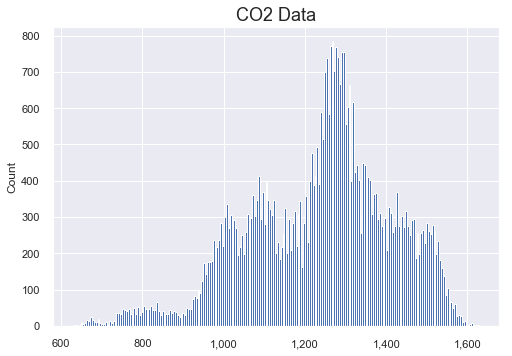

In [44]:
# Plot a histogram of the updated CO2 data
plotHistogram(co2_data, 'co2', 'CO2 Data')

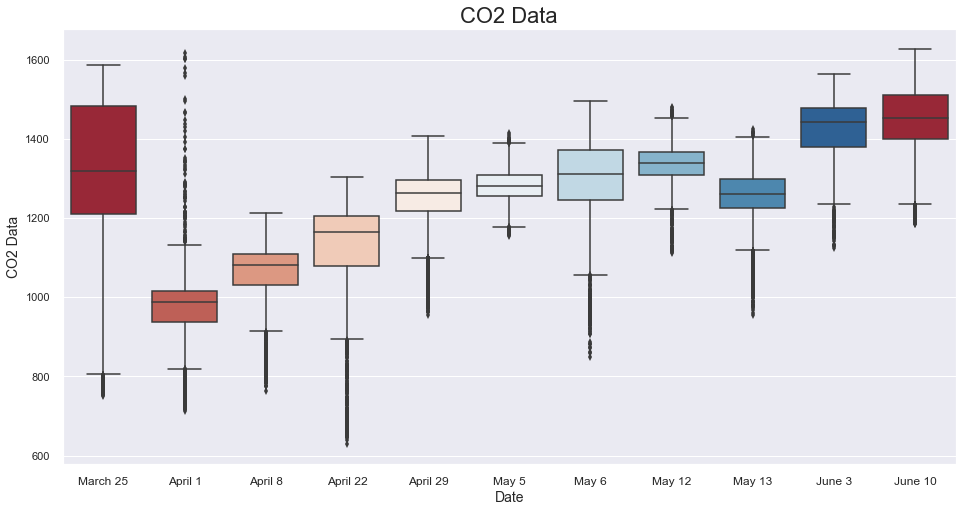

In [45]:
# Plot boxplots of the daily CO2 data
plotBoxplots(co2_data, 'co2', 'CO2 Data')

In [46]:
# Resample CO2 data to per-minute interval
co2 = co2_data.resample('T').mean().dropna()

### Sound Data

    Type of Sensor: Electret Microphone Amplifier MAX4466  
    Sensor Range: 0 to 20K Hz

    Reference: Human speech frequencies are in the range of 500 Hz to 4,000 Hz. A young person with normal hearing can hear frequencies between approximately 20 Hz and 20,000 Hz. 

In [47]:
# Create noise dataframe with DateTimeIndex: sound_data
sound_data = df[['sound']].copy()

In [48]:
# Summary statistics for the sound data
sound_data.describe()

,sound
count,46275.000000
mean,283.936704
std,174.322552
min,0.000000
25%,144.000000
50%,145.000000
75%,495.000000
max,1023.000000


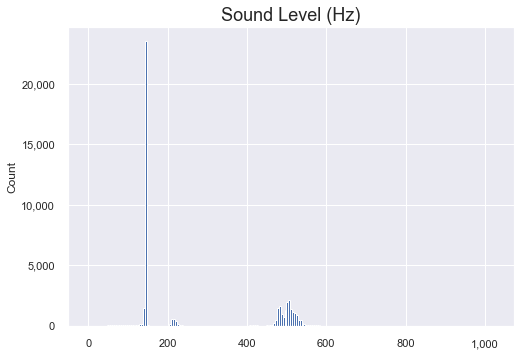

In [49]:
# Plot a histogram of the sound data
plotHistogram(sound_data, 'sound', 'Sound Level (Hz)')

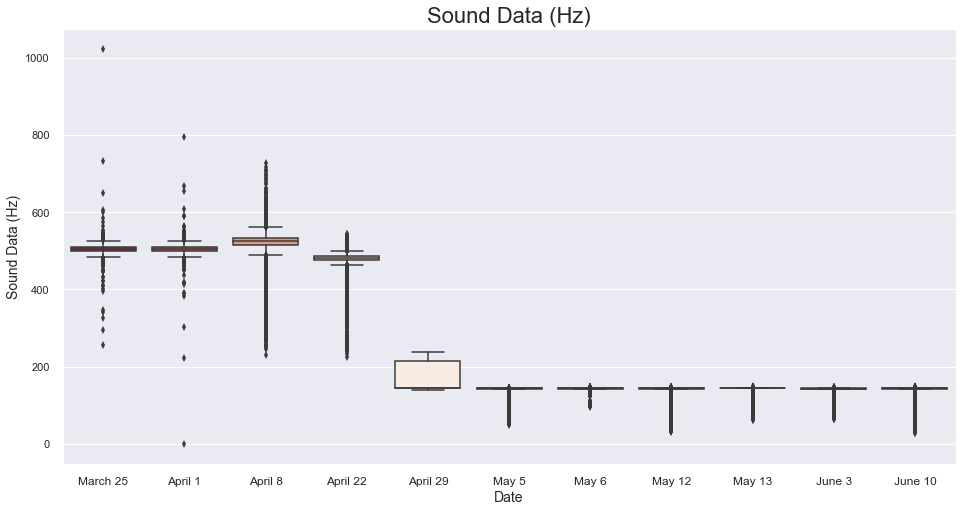

In [50]:
# Plot Boxplots for daily sound data
plotBoxplots(sound_data, 'sound', 'Sound Data (Hz)')

In [51]:
# ToDo: explore sound outliers

In [52]:
# Resample sound data
sound = sound_data.resample('T').mean().dropna()

### Light Data

    Type of Sensor: Photoresistor GL5537

    Reference: Illuminance is measured in foot candles or lux (in the metric SI system). GSA recommends a nominal illumination level (Lumens/Square Meter lux) of 300 for conference rooms, or 500 Lux in work station space, open and closed offices, and in training rooms.

    For Reference: The sensor has a light resistance of 10 Lux (30 to 50 kohm).

In [53]:
# Create light dataframe with DateTimeIndex: light_data
light_data = df[['light']].copy()

In [54]:
# Summary statistics for the light data
light_data.describe()

,light
count,4.627500e+04
mean,2.923096e+03
std,1.494275e+05
min,0.000000e+00
25%,1.780000e+02
50%,2.070000e+02
75%,3.830000e+02
max,1.000000e+07


The light sensor generated several large error values or 0 readings when it would restart. In addition, it also generated error values at the end of the day when it was turned off. In the following plot of light data on May 5th, the light values never went over 400 lux until the final seconds of the day.

In [55]:
# Identify the high error values
light_max = light_data[light_data['light'] > 4000]
light_max['light']

datetime
2017-04-08 14:02:54    9306527.000
2017-04-22 11:56:44    7718174.000
2017-04-22 12:53:51    8308485.000
2017-04-22 14:10:58    8016883.000
2017-04-29 12:23:45    9999999.999
2017-04-29 14:33:24    9999999.999
2017-04-29 15:57:55    9999999.999
2017-04-29 16:03:05       4042.000
2017-04-29 16:03:10       4052.000
2017-05-06 11:13:38    8009105.000
2017-05-12 18:26:26    8707175.000
2017-05-12 20:46:56    8725352.000
2017-05-13 09:02:19    9135322.000
2017-06-10 10:57:31    8281044.000
2017-06-10 12:30:24    9273526.000
Name: light, dtype: float64

While a light value of 0 is possible, it's unlikely since even with the classroom lights turned off, there still would have been light from the hallway. In addition, I concluded that these 0 values were errors since they were isolated readings, as can be seen below.

The light sensor generated several large error values or 0 readings when it would restart. In addition, it also generated error values at the end of the day when it was turned off. In the following plot of light data on May 5th, the light values never went over 400 lux until the final seconds of the day.

In [56]:
# Look at 0 light reading on March 25, 2017
light_data.light['March 25, 2017 11:48:20':'March 25, 2017 11:49:00']

datetime
2017-03-25 11:48:22    463.0
2017-03-25 11:48:28    454.0
2017-03-25 11:48:34    465.0
2017-03-25 11:48:40      0.0
2017-03-25 11:48:46    462.0
2017-03-25 11:48:52    461.0
2017-03-25 11:48:58    445.0
Name: light, dtype: float64

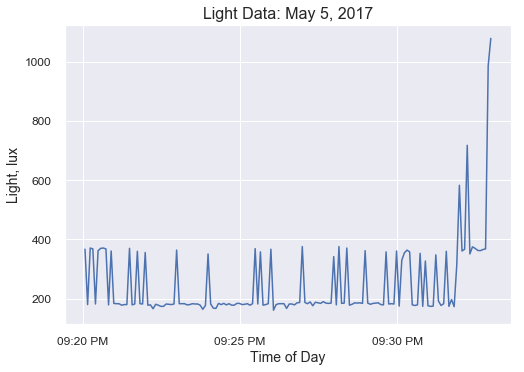

In [57]:
# Plot light data for May 5, 2017
fig, ax = plt.subplots()

ax.plot(light_data.loc['May 5, 2017 21:20:00':'May 5, 2017 22:00:00'])
ax.set_title('Light Data: May 5, 2017', fontsize=16)
ax.set_xlabel('Time of Day', fontsize=14)
ax.set_ylabel('Light, lux', fontsize=14)
ax.tick_params(labelsize=12)
ax.xaxis.set_major_formatter(md.DateFormatter('%I:%M %p'))
plt.show()

In [58]:
# Identify how many 0 light values are in the data
len(light_data[light_data['light'] == 0])

12

In [59]:
# Delete error 0 light values
light_data = light_data[light_data['light'] != 0]

In [60]:
# Delete error light values
light_data = light_data[light_data['light'] < 4000]

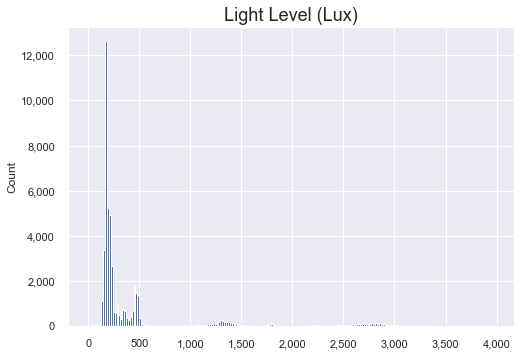

In [61]:
# Plot updated histogram of light data
plotHistogram(light_data, 'light', 'Light Level (Lux)')

While a light value of 0 is possible, it's unlikely since even with the classroom lights turned off, there still would have been light from the hallway. In addition, I concluded that these 0 values were errors since they were isolated readings, as can be seen below.

In [62]:
# Look at 0 light reading on March 25, 2017
light_data.light['March 25, 2017 11:48:20':'March 25, 2017 11:49:00']

datetime
2017-03-25 11:48:22    463.0
2017-03-25 11:48:28    454.0
2017-03-25 11:48:34    465.0
2017-03-25 11:48:46    462.0
2017-03-25 11:48:52    461.0
2017-03-25 11:48:58    445.0
Name: light, dtype: float64

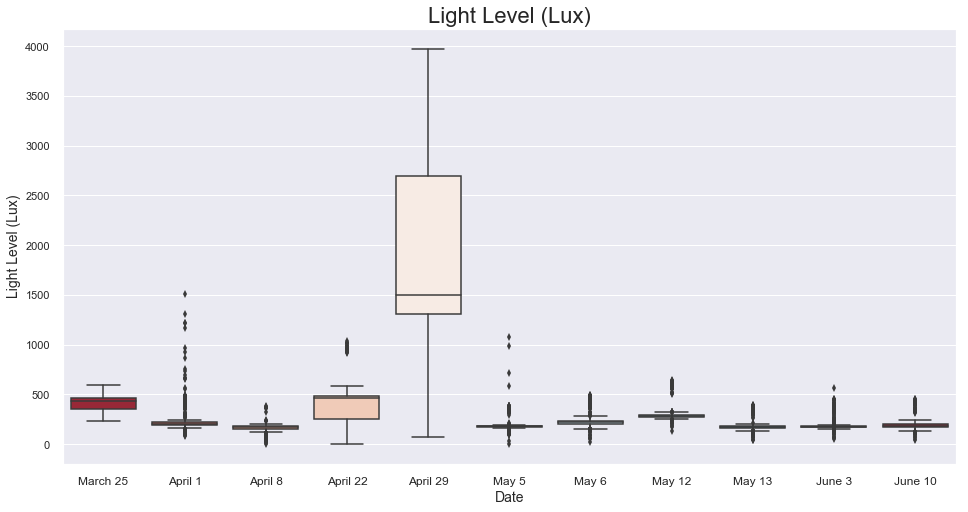

In [63]:
# Plot updated box plots for light data
plotBoxplots(light_data, 'light', 'Light Level (Lux)')

In [64]:
# ToDo: look into the remaining outliers

In [65]:
# Resample light data
light = light_data.resample('T').mean().dropna()

In [66]:
# Updated light summary statistics
light.describe()

,light
count,4157.000000
mean,418.270571
std,529.414280
min,135.000000
25%,178.833333
50%,211.000000
75%,383.750000
max,2891.583333


### Bluetooth Devices

The Raspberry Pi 3 Model B comes with its own built in wifi and Bluetooth Low Energy (LE), so we were able to scan for the number of bluetooth devices. Since we were not able to limit the area we scanned to only our classroom, the sensor picked up devices from other classrooms. However, since we were in the same classroom each day, we still thought it could be a predictive variable.

In [67]:
# Create bluetooth devices dataframe with DateTimeIndex: bluetooth_data
bluetooth_data = df[['bluetooth_devices']].copy()

In [68]:
# Summary statistics for the bluetooth data
bluetooth_data.describe()

,bluetooth_devices
count,46275.00000
mean,220.83369
std,140.24883
min,0.00000
25%,116.00000
50%,181.00000
75%,309.00000
max,635.00000


Looking at the summary statistics for `bluetooth_devices`, I was surprised that the minimum value was zero, since each of the students setting up the sensors had multiple devices emitting bluetooth signals.

When I looked into the data further, I found that similar to other devices, the first value recorded for each day was incorrect. Here, on May 5th, we can see that the first value is zero and immediately jumps to 30 and continues to rise.

In [69]:
# Look at the lowest values for May 5th
bluetooth_data['bluetooth_devices']['May 5, 2017'].head(10)

datetime
2017-05-05 18:13:53     0
2017-05-05 18:13:58    30
2017-05-05 18:14:03    31
2017-05-05 18:14:08    31
2017-05-05 18:14:13    32
2017-05-05 18:14:18    34
2017-05-05 18:14:23    34
2017-05-05 18:14:28    38
2017-05-05 18:14:33    39
2017-05-05 18:14:38    39
Name: bluetooth_devices, dtype: int64

Unfortunately, unlike the other sensors, I found that when the bluetooth sensor was first started or when it randomly restarted, it would take a significant amount of time for it build back up. This can be seen by plotting the `bluetooth_devices` values for May 5, 2017. All through the morning, the number of devices is gradually increasing, until it suddenly restarts and drops to zero, and then begins slowing rising again.

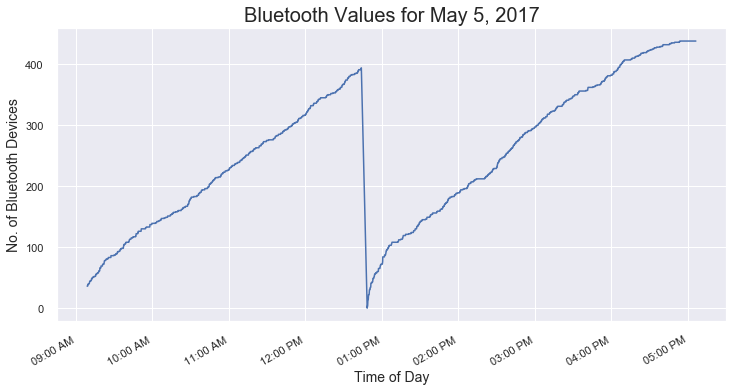

In [70]:
# Plot the bluetooth values for May 5, 2017
fig, ax = plt.subplots(figsize=(12,6))
bluetooth_data['bluetooth_devices']['2017-04-01'].plot()

# Add a title and labels
ax.set_title('Bluetooth Values for May 5, 2017', fontsize=20)
ax.set_xlabel('Time of Day', fontsize=14)
ax.xaxis.set_major_formatter(md.DateFormatter('%I:%M %p'))
ax.set_ylabel('No. of Bluetooth Devices', fontsize=14)

# Show the plot
plt.show()

Another serious issue I discovered was that there were long periods of time when the sensor only recorded zeros. For example, on April 29th, only zero values were recorded for almost an hour and a half.

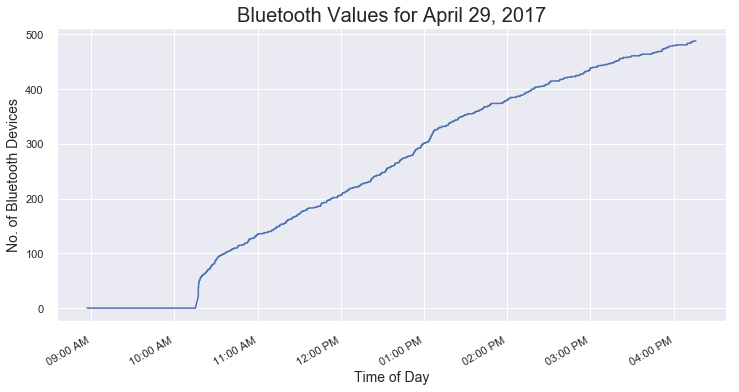

In [71]:
# Identify the number of 0 values
fig, ax = plt.subplots(figsize=(12,6))
bluetooth_data['bluetooth_devices']['2017-04-29'].plot()

# Add a title and labels
ax.set_title('Bluetooth Values for April 29, 2017', fontsize=20)
ax.set_xlabel('Time of Day', fontsize=14)
ax.xaxis.set_major_formatter(md.DateFormatter('%I:%M %p'))
ax.set_ylabel('No. of Bluetooth Devices', fontsize=14)

# Show the plot
plt.show()

Unfortunately, given these issues, I won't be able to use the bluetooth data that we collected. Initially, I had considered different methods to fill the missing data/zero values. However, after plotting the data, I don't believe that the sensor accurately captured the number of devices.

I know from my own experience on campus that a large number of students and professors arrived in the morning and stayed until the end of the day, but the plots show a small number of devices each morning and then a gradual increase throughout the day. Furthermore, there is no decline during lunchtime. Our building only had one small coffee shop that sold a small selection of drinks and snacks, so for lunch the overwhelming majority of students and faculty left the building.

### Images

    Type of Sensor: Raspberry Pi Camera Module v2

Initially, to capture the ground truth for our dataset, our team setup an 8-megapixel camera with a wide-angle lens to take pictures of the classroom at one-minute intervals. Unfortunatly, due to time restraints, we were not able to use them for that purpose. Furthermore, when we asked our fellow students for their permission to take pictures at the beginning of the project, we had promised them that the pictures would be deleted at the end of the semester, so they are no longer available. 

However, our team was still able to capture data from the images by calculating the "closeness" based on the root-mean-square error (RMSE) between successive images. For identical images, the difference between them would be zero, so higher values indicate a greater divergence.

In [72]:
# Create image dataframe with DateTimeIndex: image_data
image_data = pd.read_csv('../data/image_variations.csv', index_col='datetime', parse_dates=True)

# Rename the rolling_rms column to image_rms
image_data.rename({'rolling_rms':'image_rms'}, axis=1, inplace=True)

In [73]:
# Summary statistics for the image data
image_data.describe()

,control_F_rms,control_L_rms,image_rms
count,4469.000000,4469.000000,4469.000000
mean,35.647687,34.007843,13.331265
std,14.392077,10.525568,5.699915
min,0.000000,0.000000,0.000000
25%,24.656496,28.102343,10.005781
50%,28.884805,31.930907,12.042529
75%,46.719821,35.002443,15.774376
max,70.657752,69.706517,64.560408


In [74]:
# View the first five rows of the image data
image_data.head()

,control_F_rms,control_L_rms,image_rms
datetime,,,
2017-03-25 09:11:00,0.000000,68.764028,0.000000
2017-03-25 09:12:00,15.242697,69.110523,15.242697
2017-03-25 09:13:00,15.526992,69.169608,15.087697
2017-03-25 09:14:00,18.106792,69.253149,15.422978
2017-03-25 09:15:00,19.040465,69.159929,14.799398


Since we are calculating the change between successive images, the first value for each class period is zero.

In [75]:
# Identify the 0 values in the image data
image_data[image_data['image_rms'] == 0]

,control_F_rms,control_L_rms,image_rms
datetime,,,
2017-03-25 09:11:00,0.0,68.764028,0.0
2017-04-01 09:06:00,0.0,44.664898,0.0
2017-04-08 09:04:00,0.0,35.672150,0.0
2017-04-22 08:36:00,0.0,60.087447,0.0
2017-04-29 08:52:00,0.0,20.514254,0.0
2017-05-05 18:15:00,0.0,21.546584,0.0
2017-05-06 08:59:00,0.0,24.173091,0.0
2017-05-12 18:27:00,0.0,31.552215,0.0
2017-05-13 08:40:00,0.0,51.595340,0.0


So I'll delete the zero values now and then backfill them when concatenating the image data. In addition, I can delete the `control_F_rms` and `control_L_rms` columns now, since they are no longer needed.

In [76]:
# Delete zero values in the image data
image_data = image_data[image_data['image_rms'] != 0]

# Delete the control_F_rms and control_L_rms columns from the image data
image_data.drop(['control_F_rms', 'control_L_rms'], axis=1, inplace=True)

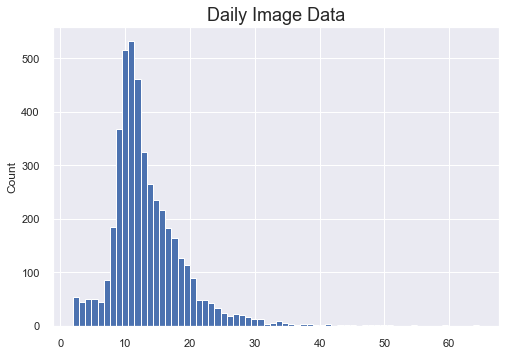

In [77]:
# Plot histogram of daily image data
plotHistogram(image_data, 'image_rms', 'Daily Image Data')

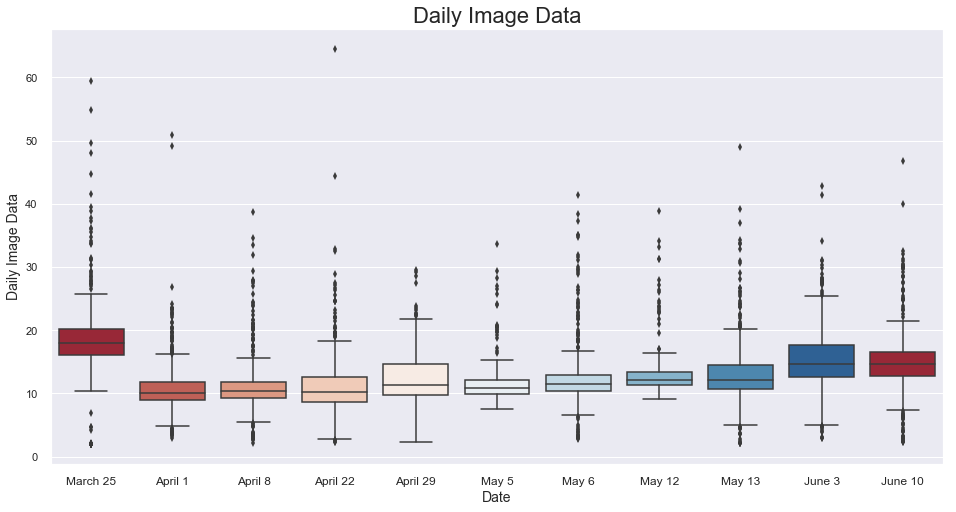

In [78]:
# Plot boxplots for daily image data
plotBoxplots(image_data, 'image_rms', 'Daily Image Data')

In [79]:
# ToDo: investigate outliers

In the following chart, you can see that the largest changes occurred during our class breaks, lunch, and at the end of the day. Typically, our professors gave us a 5-10 minute break in the morning between 10:00 am and 10:30 am and in the afternoon between 2:00 pm and 2:30 pm. Our lunch break was an hour long and most often began at 12:00 pm. Class ended approximately at 4:00 pm, but typically some students stayed afterwards to talk with the professor or to meet with the teammates, so we tried to stay until 4:30 pm to capture these changes.

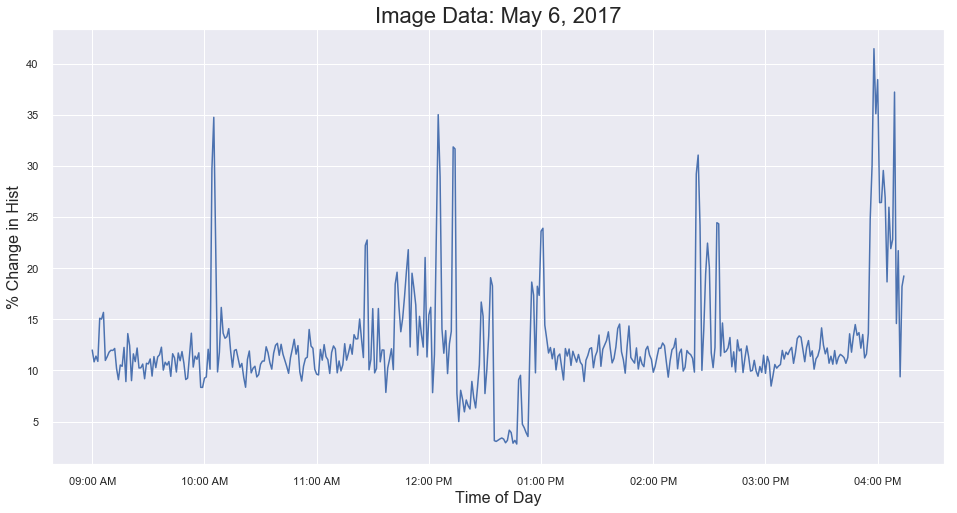

In [80]:
# Create the figure and the axes
fig, ax = plt.subplots(figsize=(16,8))

# Plot image data for May 6, 2017
ax.plot(image_data.loc['May 6, 2017'])

# Add title and labels
ax.set_title('Image Data: May 6, 2017', fontsize=22)
ax.set_xlabel('Time of Day', fontsize=16)
ax.set_ylabel('% Change in Hist', fontsize=16)
ax.xaxis.set_major_formatter(md.DateFormatter('%I:%M %p'))

# Show plot
plt.show()

*Since the images were taken each minute, I don't need to resample this DataFrame.*

### Occupancy Data

Our team created a Flask web application to log the number of people in the classroom. During breaks, one team member would use it to log each person who entered or exited the room. The app also included an "Empty Room" option that set the counter to 0. This was used most often used during the lunch break when there was no one from our group in the classroom to keep track of the number of occupants and at the end of the day. While we had originally intended to use the images to determine the total number of students in the classroom, we ultimately had to use the data generated by the Flask app.

In [81]:
# Create occupancy count dataframe with DateTimeIndex: occupancy_data
occupancy_data = pd.read_csv('../data/occupancy_data.csv', index_col='datetime', parse_dates=True)

In [82]:
# Delete the unnecessary columns
occupancy_data.drop(['location', 'count_operation', 'count_change'], axis=1, inplace=True)

# Drop data for March 18, 2017
occupancy_data.drop(occupancy_data.loc['2017-03-18'].index, inplace=True)

In [83]:
# Occupancy summary statistics
occupancy_data.describe()

,count_total
count,2298.000000
mean,18.888599
std,7.853676
min,0.000000
25%,14.000000
50%,20.000000
75%,26.000000
max,31.000000


The occupancy data contains 21 zero values. When I looked into the source of these values, I found that eleven of them were the last values of the day. For example, you can see below that at the end of the class period on March 25th, the number of occupants had started to decline as students left for the day, until suddenly the number went from 13 to 0. 
The reason for this sharp decline would have been, that since it was the end of the day, one of our team members would have clicked the "Empty Room" option on the Flask app. 

In [84]:
# Identify the zero value at the end of March 25, 2017
occupancy_data['2017-03-25'].tail(10)

,count_total
datetime,
2017-03-25 16:15:49.514,17
2017-03-25 16:17:36.957,16
2017-03-25 16:17:38.390,15
2017-03-25 16:18:38.594,16
2017-03-25 16:18:40.765,17
2017-03-25 16:19:38.807,16
2017-03-25 16:19:39.486,15
2017-03-25 16:19:40.085,14
2017-03-25 16:32:00.619,13


The remaining zero values occurred when the students left for lunch. Our team tried to stay in the room until it was empty, but sometimes a few students would remain and we needed to take our break. You can see this below as the number starts to dwindle just after noon, until the number of occupants drops from 4 to zero. Since I want to keep the last value when resampling the occupancy data, I decided to delete these zero values since they don't accurately reflect the room's occupancy level at the time. 

In [85]:
# Identify the zero value during lunch time on April 29, 2017
occupancy_data['2017-04-29 12:03']

,count_total
datetime,
2017-04-29 12:03:00.654,7
2017-04-29 12:03:08.546,6
2017-04-29 12:03:13.341,5
2017-04-29 12:03:17.889,4
2017-04-29 12:03:27.578,0


In [86]:
# Delete the 0 values from the occupancy data
occupancy_data = occupancy_data[occupancy_data['count_total'] != 0]

#### Resample Occupancy Data

Most often, when students were entering or leaving the classroom, a large number of them would do so at the same time. For example, when leaving for lunch or coming back from a break. Therefore, the Flask app kept track of changes in milliseconds.

However, I did not want to resample the occupancy data by taking the mean of the values per-minute, like the other sensor values. To understand why, below you can see that for one minute, at 8:57 am on April 29th, we had a total of 19 values recorded. If we were just take the mean of that data, it would be 9.68. However, since this was happening at a time when a large number of students were coming into the room, the room's occupancy went from 1 to 17 at that time. Therefore, when resampling the data, a more accurate measure would be to keep the last value during that time frame, which in this case would be 17.

In [87]:
# Show the values for April 29 at 8:57 am
occupancy_data['2017-04-29 08:57']

,count_total
datetime,
2017-04-29 08:57:14.854,1
2017-04-29 08:57:15.145,2
2017-04-29 08:57:15.409,3
2017-04-29 08:57:15.651,4
2017-04-29 08:57:15.904,5
2017-04-29 08:57:16.225,6
2017-04-29 08:57:16.505,7
2017-04-29 08:57:16.790,8
2017-04-29 08:57:17.063,9


In [88]:
# Resample occupancy data per minute and drop any NaN values
occupancy = occupancy_data.resample(rule='T', how='last').dropna()

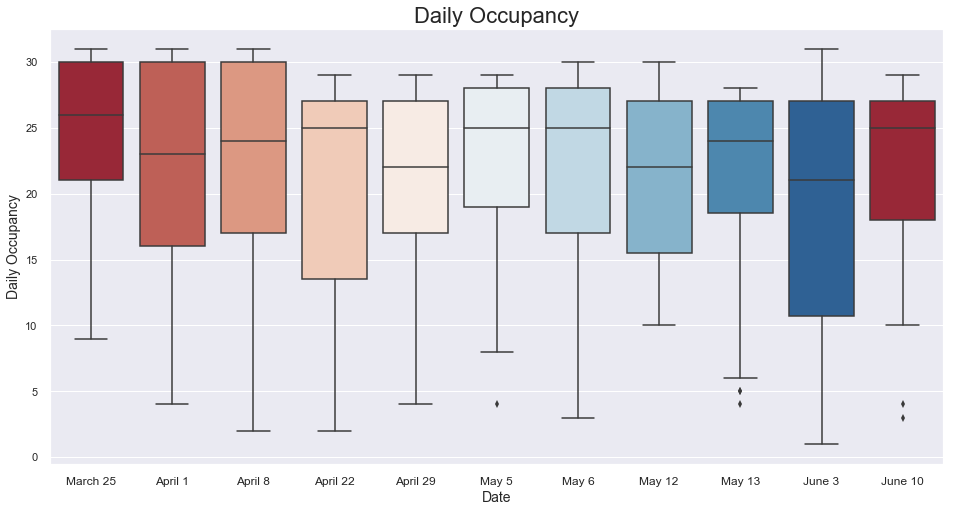

In [89]:
# Plot boxplots for daily occupancy data
plotBoxplots(occupancy, 'count_total', 'Daily Occupancy')

## Concatenate Sensor Data

Now that I've finished cleaning and resampling the individual sensor values (with the exception of the door data, which will be explained later), I'll concatenate them into a single DataFrame, backfilling any missing values.

In [90]:
# Concatenate cleaned sensor data in a new dataframe: sensor_data
sensor_data = pd.concat(
    [temperature, humidity, co2, light, sound, image_data, occupancy], axis=1).fillna(method='bfill').dropna()

sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4519 entries, 2017-03-25 09:05:00 to 2017-06-10 16:42:00
Data columns (total 7 columns):
temperature    4519 non-null float64
humidity       4519 non-null float64
co2            4519 non-null float64
light          4519 non-null float64
sound          4519 non-null float64
image_rms      4519 non-null float64
count_total    4519 non-null float64
dtypes: float64(7)
memory usage: 282.4 KB


### Door Status

The door sensor is an asynchronistic categorical feature with two possible values: `closed` and `opened`. In addition, it has roughly an equal number of both values.

In [91]:
# Create door data dataframe with DateTimeIndex: door_status
door_data = pd.read_csv('../data/door_data.csv', index_col='datetime', parse_dates=True)

# Drop the location column
door_data.drop('location', axis=1, inplace=True)

In [92]:
# View the head of the door data
door_data.head()

,door_status
datetime,
2017-03-25 09:03:28,opened
2017-03-25 09:03:36,closed
2017-03-25 09:04:09,opened
2017-03-25 09:04:13,closed
2017-03-25 09:07:14,opened


In [93]:
# Count the number of each category value
door_data['door_status'].value_counts()

opened    1650
closed    1636
Name: door_status, dtype: int64

While it is a binary variable, I couldn't simply encode it with 1 for `opened` and 0 for `closed`, since I also wanted to resample the data. So instead, I started by using pandas `get_dummies` function.

In [94]:
# Encode the door feature
door_data = pd.get_dummies(door_data)

# View the head of the door data
door_data.head()

,door_status_closed,door_status_opened
datetime,,
2017-03-25 09:03:28,0,1
2017-03-25 09:03:36,1,0
2017-03-25 09:04:09,0,1
2017-03-25 09:04:13,1,0
2017-03-25 09:07:14,0,1


In [95]:
door_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3286 entries, 2017-03-25 09:03:28 to 2017-06-10 16:42:50
Data columns (total 2 columns):
door_status_closed    3286 non-null uint8
door_status_opened    3286 non-null uint8
dtypes: uint8(2)
memory usage: 32.1 KB


Then to resample the data, I want to sum the number of the times the door had opened and closed each minute, rather than calculating the mean value. However, an unexpected side effect to this strategy was that it created zero values to be generated for *every* minute between the first and last date in the dataset, even when both column values were zero. This meant going from 3,286 to 111,340 instances. 

In [96]:
# Resample door status data
door = door_data.resample('T').sum()

# View the head of the door data
door.head()

,door_status_closed,door_status_opened
datetime,,
2017-03-25 09:03:00,1,1
2017-03-25 09:04:00,1,1
2017-03-25 09:05:00,0,0
2017-03-25 09:06:00,0,0
2017-03-25 09:07:00,1,1


So before merging the door data with the larger sensor dataset, I'll drop those rows.

In [97]:
# Drop rows where both values are zero
door = door.drop(door[(door['door_status_closed'] == 0) & (door['door_status_opened'] == 0)].index)

In [98]:
# Merge the resampled door data onto the sensor dataframe
sensor_data = sensor_data.merge(door, left_index=True, right_index=True)

# Rename the dataframe columns
sensor_data.columns = [
                      'temp', 'humidity', 'co2', 'light', 'sound',
                      'images', 'occupancy', 'dr_closed', 'dr_opened'
]

sensor_data.head()

,temp,humidity,co2,light,sound,images,occupancy,dr_closed,dr_opened
datetime,,,,,,,,,
2017-03-25 09:07:00,23.85,38.910000,768.300000,422.400000,510.400000,15.242697,15.0,1,1
2017-03-25 09:21:00,24.34,38.110000,841.900000,415.200000,505.300000,16.307887,29.0,0,1
2017-03-25 09:34:00,24.80,37.433333,937.000000,360.000000,505.000000,17.447324,29.0,0,1
2017-03-25 09:59:00,25.80,37.488889,1167.222222,436.777778,501.444444,16.336018,30.0,0,1
2017-03-25 10:16:00,25.80,37.488889,1167.222222,436.777778,501.444444,28.639320,31.0,2,1


In [99]:
# Summary statistics for sensor data
sensor_data.describe()

,temp,humidity,co2,light,sound,images,occupancy,dr_closed,dr_opened
count,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000
mean,23.213857,38.849334,1238.560280,385.335465,286.083086,16.740164,21.465574,1.785792,1.800000
std,1.489213,6.839061,195.264209,499.450288,176.280918,8.151946,7.880929,2.957025,2.967069
min,21.000000,21.200000,666.000000,135.000000,33.000000,2.196979,1.000000,0.000000,0.000000
25%,22.454167,37.586667,1120.909091,174.916667,143.591667,11.514630,16.000000,1.000000,1.000000
50%,22.900000,39.425000,1260.000000,194.333333,144.166667,15.311687,24.000000,1.000000,1.000000
75%,23.300000,42.904167,1386.500000,372.166667,498.111111,20.461975,28.000000,2.000000,2.000000
max,29.350000,50.730000,1555.333333,2869.416667,574.000000,64.560408,31.000000,46.000000,47.000000


### Create Category Variable

Finally, I'll create a new variable by splitting `occupancy` into different levels. This will be my target variable when building classification models, while I'll use `occupancy` for regression models.

Unfortunately, the target variable is highly imbalanced toward high occupancy, which I did expect since the classroom was largely filled throughout the day, except during breaks and lunchtime. Our team did try to balance our dataset by leaving our sensors in the room overnight, but our plan was thwarted by a well-meaning cleaning lady.

In [100]:
# Create target array by slicing 'occupancy_count' column: occupancy_level
sensor_data['occupancy_level'] = pd.cut(sensor_data['occupancy'], [0, 13, 25, 31],
                                        labels=['low', 'mid-level', 'high'], include_lowest=True)

In [108]:
sensor_data

,temp,humidity,co2,light,sound,images,occupancy,dr_closed,dr_opened,occupancy_level
datetime,,,,,,,,,,
2017-03-25 09:07:00,23.850000,38.910000,768.300000,422.400000,510.400000,15.242697,15.0,1,1,mid-level
2017-03-25 09:21:00,24.340000,38.110000,841.900000,415.200000,505.300000,16.307887,29.0,0,1,high
2017-03-25 09:34:00,24.800000,37.433333,937.000000,360.000000,505.000000,17.447324,29.0,0,1,high
2017-03-25 09:59:00,25.800000,37.488889,1167.222222,436.777778,501.444444,16.336018,30.0,0,1,high
2017-03-25 10:16:00,25.800000,37.488889,1167.222222,436.777778,501.444444,28.639320,31.0,2,1,high
2017-03-25 10:17:00,25.800000,37.488889,1167.222222,436.777778,501.444444,31.307884,31.0,2,2,high
2017-03-25 10:18:00,25.800000,37.488889,1167.222222,436.777778,501.444444,27.383427,31.0,2,2,high
2017-03-25 10:19:00,25.800000,37.488889,1167.222222,436.777778,501.444444,24.939213,31.0,3,4,high
2017-03-25 10:20:00,25.800000,37.488889,1167.222222,436.777778,501.444444,48.105349,31.0,1,0,high


In [101]:
# Value counts for occupancy_level
sensor_data.occupancy_level.value_counts()

high         404
mid-level    338
low          173
Name: occupancy_level, dtype: int64

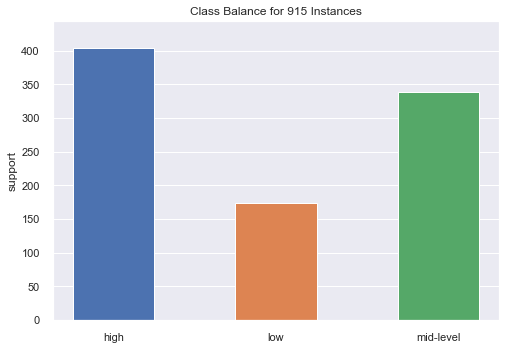

In [102]:
visualizer = ClassBalance()
visualizer.fit(sensor_data['occupancy_level'])
visualizer.poof()

In [103]:
sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 915 entries, 2017-03-25 09:07:00 to 2017-06-10 16:42:00
Data columns (total 10 columns):
temp               915 non-null float64
humidity           915 non-null float64
co2                915 non-null float64
light              915 non-null float64
sound              915 non-null float64
images             915 non-null float64
occupancy          915 non-null float64
dr_closed          915 non-null uint8
dr_opened          915 non-null uint8
occupancy_level    915 non-null category
dtypes: category(1), float64(7), uint8(2)
memory usage: 60.0 KB


## Save Data

In [104]:
# Rearrange columns
classification_data = sensor_data[[
    'temp', 'humidity', 'co2', 'light', 'sound', 'images',
    'dr_closed', 'dr_opened', 'occupancy_level']]

In [105]:
# Export sensor data for classification models to a CSV file: classification_data.csv
classification_data.to_csv('../data/classification_data.csv')

In [106]:
# Rearrange columns
regression_data = sensor_data[[
    'temp', 'humidity', 'co2', 'light', 'sound', 'images',
    'dr_closed', 'dr_opened', 'occupancy']]

In [107]:
# Export sensor data for regression models to a CSV file: regression_data.csv
regression_data.to_csv('../data/regression_data.csv')